In [1]:
import h5py

In [2]:
import torch
from torch.nn import functional as F

In [3]:
import flow_vis
import numpy as np

from matplotlib import pyplot as plt

In [5]:
import cv2
from torchvision.transforms import Resize
from pytlsd import lsd

In [18]:
import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, '..'))

In [19]:
from gluefactory.utils.experiments import load_experiment
from gluefactory.models.extractors.jpldd.joint_point_line_extractor import JointPointLineDetectorDescriptor

In [20]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [82]:
name = '255027795_2652471757_o'
# name = '17450068_dc7884b082_o'
name = '562094050_5938f37ea5_o'
name = '00080'

torch.Size([1, 3, 800, 800])


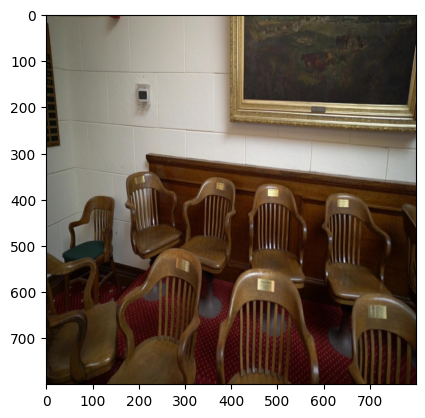

In [83]:
conf_lines = {
    "min_length": 25,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

size = (800,800)

conf_homography = {
    'translation': True,
    'rotation': True,
    'scaling': True,
    'perspective': True,
    'scaling_amplitude': 0.2,
    'perspective_amplitude_x': 0.2,
    'perspective_amplitude_y': 0.2,
    'patch_ratio': 0.85,
    'max_angle': 1.57,
    'allow_artifacts': True
}
resize_func = Resize(size)
image_path = f"../experiments/data/{name}.jpg"
img = cv2.resize(cv2.imread(image_path),size)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_torch = numpy_image_to_torch(img)
img_torch = img_torch.unsqueeze(0)

print(img_torch.shape)
plt.imshow(rgb_img)
plt.show()

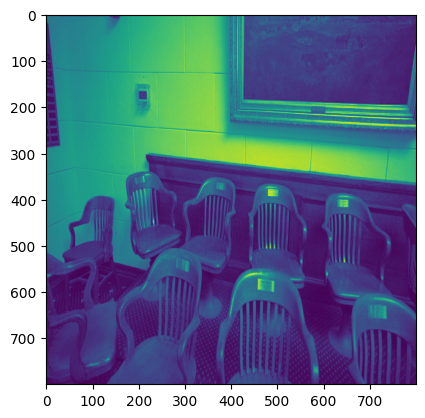

In [84]:
scale = img_torch.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
gs_image = (img_torch * scale).sum(1, keepdim=True)
np_gs_image = gs_image.squeeze().numpy()
plt.imshow(np_gs_image)

## GT data

In [25]:
f = h5py.File(f'../experiments/data/{name}.hdf5', 'r')

In [26]:
list(f.keys())

['deeplsd_angle_field', 'deeplsd_distance_field']

In [27]:
angle_field = f['deeplsd_angle_field']
angle_field.shape

(800, 800)

In [28]:
distance_field = f['deeplsd_distance_field']
distance_field.shape

(800, 800)

In [29]:
npaf = angle_field[()]
npaf

array([[2.4813392 , 2.4497821 , 2.5617833 , ..., 0.5927334 , 0.75951964,
        0.75376445],
       [2.4687963 , 2.5287542 , 2.6220863 , ..., 0.7695972 , 0.96384275,
        0.99879146],
       [2.5986333 , 0.15600562, 1.0888312 , ..., 1.116736  , 1.040851  ,
        1.0464172 ],
       ...,
       [1.7581791 , 1.8827055 , 1.9382733 , ..., 0.21020722, 0.32740566,
        0.28389177],
       [2.4744084 , 2.4472256 , 2.3699365 , ..., 0.31686726, 0.32315952,
        0.37525877],
       [2.3817048 , 2.4362977 , 2.4911613 , ..., 0.33574444, 0.30781484,
        0.05019309]], dtype=float32)

In [30]:
npdf = distance_field[()]
npdf

array([[2.4113448, 2.5061023, 2.7771728, ..., 2.372568 , 2.2887943,
        2.280177 ],
       [2.217276 , 2.528575 , 3.1332061, ..., 2.2577386, 2.1303868,
        2.3957613],
       [2.1844854, 2.4943008, 2.8417072, ..., 2.518577 , 2.0508182,
        2.841332 ],
       ...,
       [0.6164849, 2.25834  , 3.0666971, ..., 2.0652785, 1.028124 ,
        1.0384619],
       [3.0713844, 2.9682202, 2.7975068, ..., 1.3164814, 1.2448117,
        1.1681721],
       [2.8068345, 2.8996344, 2.9376955, ..., 1.6608405, 1.5016711,
        1.5481546]], dtype=float32)

In [31]:
f.close()

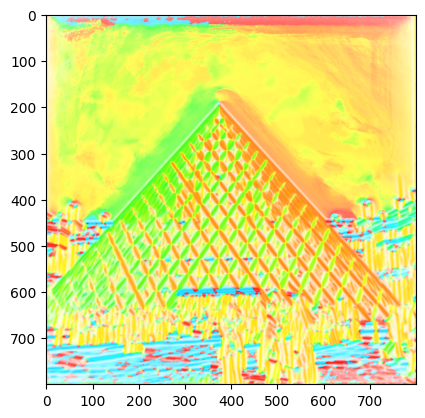

In [32]:
plt.imshow(get_flow_vis(npdf, npaf))
plt.show()

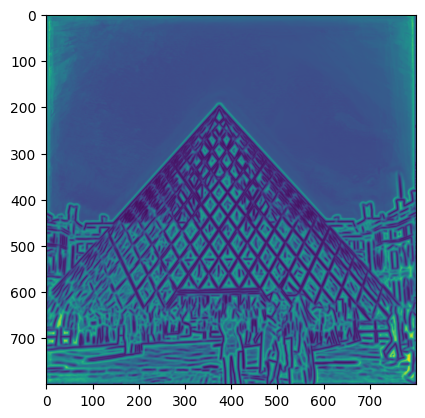

In [33]:
plt.imshow(npdf)
plt.show()

In [34]:
f = h5py.File(f'../experiments/data/sp_{name}.hdf5', 'r')

In [35]:
list(f.keys())

['superpoint_heatmap']

In [36]:
superpoint_heatmap = f['superpoint_heatmap']
superpoint_heatmap.shape

(800, 800)

In [37]:
sphm = superpoint_heatmap[()]

In [38]:
f.close()

In [39]:
sphm = np.nan_to_num(sphm, nan=0)

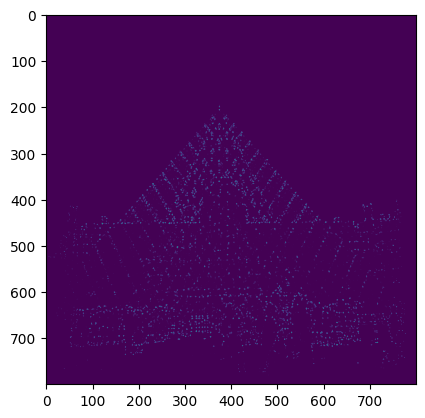

In [40]:
plt.imshow(sphm)
plt.show()

(array([8.508e+03, 3.066e+03, 1.704e+03, 1.105e+03, 8.690e+02, 7.340e+02,
        6.420e+02, 6.090e+02, 5.470e+02, 5.200e+02, 4.850e+02, 4.700e+02,
        5.200e+02, 4.990e+02, 4.360e+02, 4.290e+02, 4.080e+02, 4.070e+02,
        3.570e+02, 3.320e+02, 2.930e+02, 2.620e+02, 2.170e+02, 2.000e+02,
        1.440e+02, 1.490e+02, 1.390e+02, 1.030e+02, 8.700e+01, 7.100e+01,
        5.000e+01, 5.000e+01, 3.700e+01, 2.700e+01, 2.000e+01, 2.600e+01,
        2.100e+01, 1.000e+01, 1.000e+01, 5.000e+00, 5.000e+00, 7.000e+00,
        0.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00]),
 array([0.0050008 , 0.01603169, 0.02706259, 0.03809348, 0.04912437,
        0.06015526, 0.07118615, 0.08221705, 0.09324794, 0.10427883,
        0.11530972, 0.12634061, 0.1373715 , 0.14840239, 0.15943328,
        0.17046417, 0.18149507, 0.19252595, 0.20355685, 0.21458773,
        0.22561863, 0.23664953, 0.24768041, 0.25871131, 0.26974219,
        0.2807731 , 0.29180399, 0.30

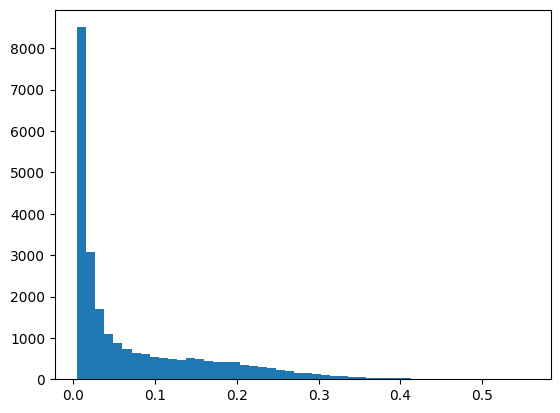

In [41]:
# hist, bins = np.histogram(sphm.reshape(-1))
plt.hist(sphm[sphm > 1e-3], bins = 50)

## Further Processing

In [374]:
def batched_nms(scores, nms_radius: int):
    assert nms_radius >= 0

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius
        )

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


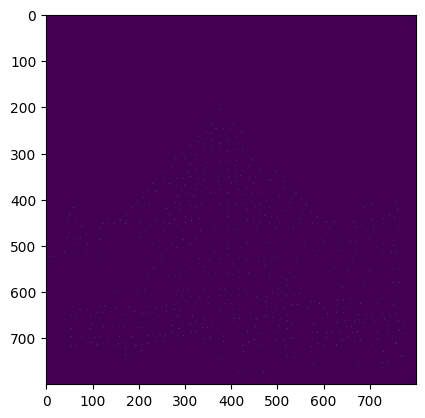

In [375]:
nms_sphm = batched_nms(torch.Tensor(sphm).unsqueeze(0), 10).squeeze()
plt.imshow(nms_sphm)
plt.show()

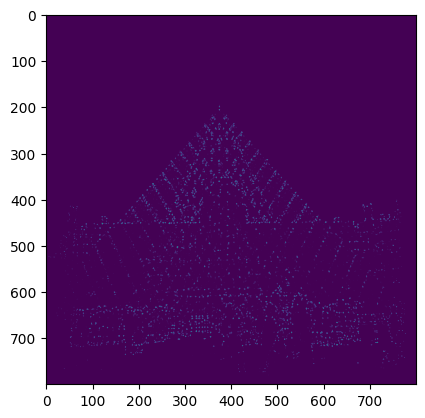

In [376]:
nsphm = sphm / sphm.max()

plt.imshow(nsphm)
plt.show()

In [377]:
nms_sphm.max()

tensor(0.5565)

In [378]:
DF_THRESH = 5

In [379]:
valid_sphm = nms_sphm.clone()
valid_sphm[npdf > DF_THRESH] = 0

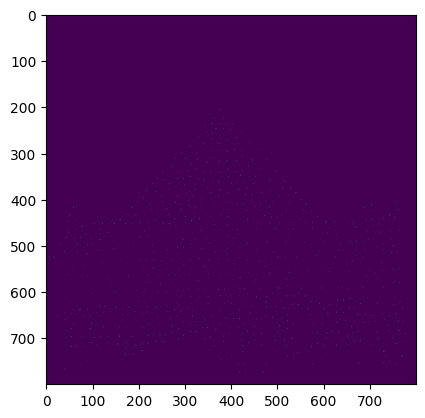

In [380]:
thresh = 0.2
sup_sphm = valid_sphm / valid_sphm.max()
sup_sphm[sup_sphm < thresh] = 0

plt.imshow(sup_sphm)
plt.show()

In [381]:
kpx, kpy = sup_sphm.nonzero().T
kpx.shape

torch.Size([689])

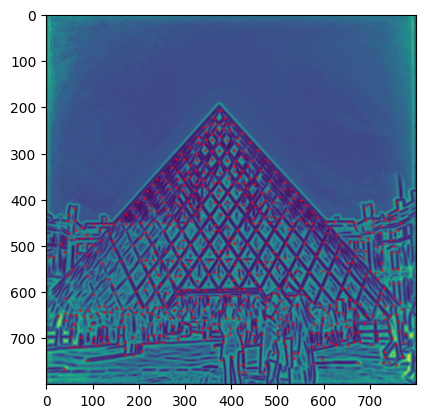

In [382]:
plt.imshow(npdf)
plt.scatter(kpy, kpx, c='r', s=0.5)
plt.show()

In [383]:
junctions = np.array([kpx, kpy]).T
junctions = np.array(sorted(junctions, key=lambda x: x.sum()))
junctions.shape

(689, 2)

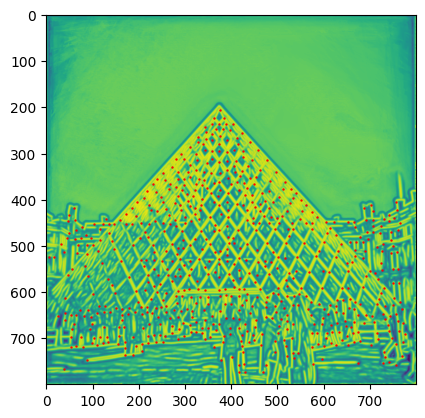

In [384]:
negnpdf = 1 - npdf / npdf.max()

plt.imshow(negnpdf)
plt.scatter(kpy, kpx, c='r', s=0.5)
plt.show()

In [385]:
(npdf / npdf.max()).mean()

0.30833825

## JPLDD

In [85]:
jpldd_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "model_name": "aliked-n16",
    "max_num_keypoints": 1000,  # setting for training, for eval: -1
    "pretrained": True,
    "timeit": True,  # override timeit: False from BaseModel
    "train_descriptors": {
        "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
        "device": None # device to house the lightweight ALIKED model
    }
}
jpldd_model = load_experiment("../experiments/weights/jpldd_09.tar", jpldd_conf)
#jpldd_model = JointPointLineDetectorDescriptor({})

[05/24/2024 19:05:08 gluefactory.utils.experiments INFO] Loading checkpoint jpldd_09.tar
Load pretrained weights for aliked parts...
Load ALiked Lightweight model for descriptor training...
[05/24/2024 19:05:08 gluefactory.utils.experiments WARNING] Missing 48 parameters in aliked_lw


In [86]:
%%time

with torch.no_grad():
    output_jpldd = jpldd_model({"image": img_torch})
output_jpldd.keys()

CPU times: user 13.3 s, sys: 3.16 s, total: 16.4 s
Wall time: 2.39 s


dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors'])

In [103]:
jpldd_kpjhm = output_jpldd['keypoint_and_junction_score_map'][0]
jpldd_af = output_jpldd['line_anglefield'][0]
jpldd_df = output_jpldd['line_distancefield'][0]
jpldd_kpr = output_jpldd['keypoints_raw'][0]
jpldd_kp = output_jpldd['keypoints'][0]
jpldd_kp_scores = output_jpldd['keypoint_scores'][0]
jpldd_desc = output_jpldd['descriptors'][0]

jpldd_kpjhm.shape, jpldd_af.shape, jpldd_df.shape, jpldd_kpr.shape, jpldd_kp.shape, jpldd_kp_scores.shape, jpldd_desc.shape

(torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([1000, 2]),
 torch.Size([1000, 2]),
 torch.Size([1000]),
 torch.Size([1000, 128]))

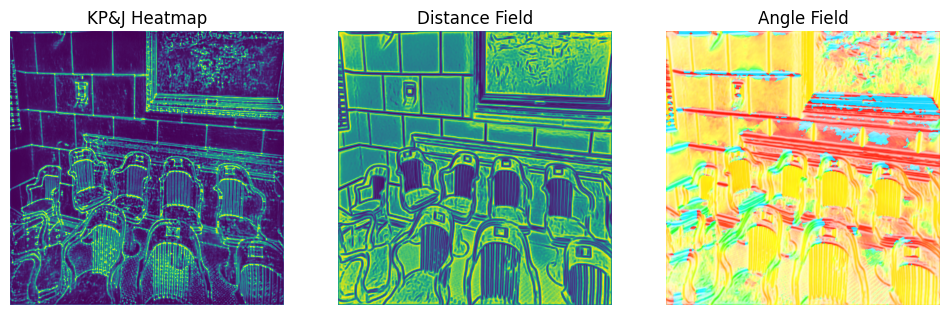

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].axis('off')
ax[0].set_title('KP&J Heatmap')
ax[0].imshow(jpldd_kpjhm)

ax[1].axis('off')
ax[1].set_title('Distance Field')
ax[1].imshow(jpldd_df)

ax[2].axis('off')
ax[2].set_title('Angle Field')
ax[2].imshow(get_flow_vis(jpldd_df, jpldd_af))
plt.show()

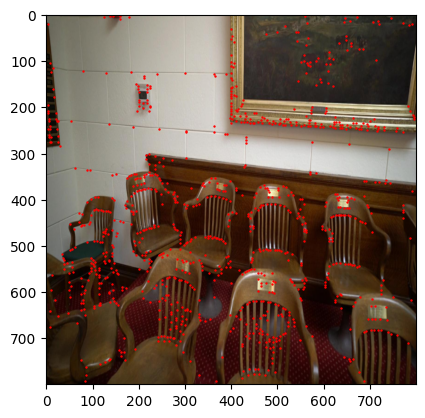

In [89]:
plt.imshow(rgb_img)
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c='r', s=0.5)
plt.show()

### Descriptor visualization

In [90]:
from sklearn.decomposition import PCA

In [91]:
pca = PCA(n_components=3)
pca.fit(jpldd_desc.numpy())

PCA(n_components=3)

In [92]:
pca_desc = pca.transform(jpldd_desc)
pca_desc

array([[ 0.23145844,  0.18499479,  0.05028912],
       [-0.09073833, -0.28841708, -0.04280365],
       [-0.11961609, -0.15931352, -0.0260145 ],
       ...,
       [-0.21537672, -0.09795181,  0.06127249],
       [ 0.18577535,  0.12056208, -0.18263725],
       [ 0.04825756, -0.17672347, -0.37635689]])

In [93]:
normalized_pca_desc = pca_desc - pca_desc.min()
normalized_pca_desc = normalized_pca_desc / normalized_pca_desc.max()
normalized_pca_desc

array([[0.66311463, 0.62778264, 0.52534947],
       [0.41810908, 0.26778979, 0.45455967],
       [0.39614979, 0.36596299, 0.46732651],
       ...,
       [0.32333129, 0.41262379, 0.53370147],
       [0.62837619, 0.57878658, 0.34822711],
       [0.52380463, 0.35272408, 0.20091841]])

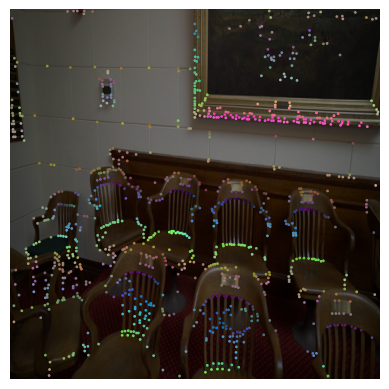

In [102]:
plt.axis('off')
# plt.title('Keypoints w/ Descriptors')
plt.imshow(rgb_img)
plt.imshow(np.zeros_like(img), alpha=0.5, cmap='gray')
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c=normalized_pca_desc, s=1)
plt.savefig('../experiments/data/kpd.png')
plt.show()

### Junctions

In [104]:
junctions = jpldd_kp

## Detection

In [105]:
junctions.shape

torch.Size([1000, 2])

In [106]:
junctions_t = torch.Tensor(junctions)
main_lines = torch.hstack([
    torch.cartesian_prod(junctions_t[:, 0], junctions_t[:, 0]),
    torch.cartesian_prod(junctions_t[:, 1], junctions_t[:, 1]),
]).reshape((-1, 2, 2))
main_lines

tensor([[[211.2641, 211.2641],
         [137.1715, 137.1715]],

        [[211.2641, 654.8185],
         [137.1715, 417.5219]],

        [[211.2641, 630.7885],
         [137.1715, 416.5206]],

        ...,

        [[629.7872, 548.6859],
         [387.4844, 703.8798]],

        [[629.7872, 582.7285],
         [387.4844, 341.4268]],

        [[629.7872, 629.7872],
         [387.4844, 387.4844]]])

In [107]:
main_lines.shape

torch.Size([1000000, 2, 2])

In [108]:
max_dist_thresh = np.inf # 50
lines = main_lines[((main_lines[:, 0, 1] - main_lines[:, 0, 0])**2 + (main_lines[:, 1, 1] - main_lines[:, 1, 0])**2) < max_dist_thresh ** 2]
lines.shape

torch.Size([1000000, 2, 2])

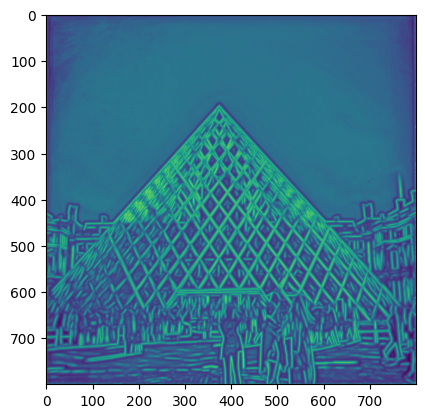

In [109]:
line_neighborhood = 5

def normalize_df(df):
    return -np.log(df / line_neighborhood + 1e-6)

def denormalize_df(df_norm):
    return np.exp(-df_norm) * line_neighborhood

normalized_df = normalize_df(npdf)
plt.imshow(normalized_df)
plt.show()

In [394]:
def get_valid_lines(
    lines, 
    df,
    n_samples=10, 
    df_thresh=5, 
    inlier_thresh=0.7,
    r_ratio=0.1, 
    a_diff_thresh=np.pi/20, 
    refinement_a_diff_thresh=np.pi/60,
    a_std_thresh=np.pi/30,
    r_radius=5,
    b_diff_thresh=5,
    check_sample=False,
):
    '''
    lines: (N, 2, 2) -> each of the N elements: [[x1, x2], [y1, y2]]
    '''
    
    validity = (lines[:, 0, 0] != lines[:, 0, 1]) & (lines[:, 1, 0] != lines[:, 1, 1])
    lines = lines[validity]

    xs = np.linspace(lines[:, 0, 0], lines[:, 0, 1], n_samples).T
    ys = np.linspace(lines[:, 1, 0], lines[:, 1, 1], n_samples).T
    xs = np.round(xs).astype(int)
    ys = np.round(ys).astype(int)

    xint = np.linspace(xs.T-r_radius, xs.T+r_radius, 2 * r_radius + 1).T.astype(int)
    yint = np.linspace(ys.T-r_radius, ys.T+r_radius, 2 * r_radius + 1).T.astype(int)

    point_indices = df[xint, yint].argmin(axis=-1)
    rows, cols = np.indices(point_indices.shape)

    valid_xs = xint[rows, cols, point_indices]
    valid_ys = yint[rows, cols, point_indices]
    
    xs, ys = valid_xs, valid_ys
    
    points = df[xs, ys]
    angles = npaf[xs, ys]

    slope = (lines[:, 0, 1] - lines[:, 0, 0]) / (lines[:, 1, 1] - lines[:, 1, 0] + 1e-10)
    direction = np.mod(np.arctan(slope), np.pi)

    inlier_indices = points < df_thresh
    inlier_ratio = (inlier_indices).sum(axis=-1) / xs.shape[-1]
    
    rows, cols = np.indices(inlier_indices.shape)
    valid_angles = angles
    
    crit1 = points.mean(axis=-1) < df_thresh
    crit2 = valid_angles.std(axis=-1) < a_std_thresh
    crit3 = inlier_ratio > inlier_thresh
    crit4 = np.mod(valid_angles.mean(axis=-1) - direction, np.pi) < a_diff_thresh

    validity = crit1 & crit2 & crit3 & crit4
    lines = lines[validity]

    # filter out the redundant lines
    filter_redundant_lines = False
    if filter_redundant_lines:
        xs = xs[validity]
        ys = ys[validity]
        
        slope = (lines[:, 0, 1] - lines[:, 0, 0]) / (lines[:, 1, 1] - lines[:, 1, 0] + 1e-10)
        direction = np.mod(np.arctan(slope), np.pi)
        b = ys[:, 0] - direction * xs[:, 0]
        redundant_b = np.repeat(b[..., np.newaxis], b.shape[0], axis=1)
        redundant_d = np.repeat(direction[..., np.newaxis], direction.shape[0], axis=1)
    
        redundancy_map = (
            np.triu(np.abs(b[..., np.newaxis] - b) < b_diff_thresh).astype(int) *
            np.triu(np.abs(direction[..., np.newaxis] - direction) < refinement_a_diff_thresh).astype(int)
        )
        redundancy_map = redundancy_map - np.eye(len(redundancy_map))
        redundant_lines = redundancy_map.nonzero()
    
        sq_lengths = (lines[:, 0, 1] - lines[:, 0, 0])**2 + (lines[:, 1, 1] - lines[:, 1, 0])**2
    
        # redundant_lines[0][sq_lengths[redundant_lines[0]] < sq_lengths[redundant_lines[1]]] = redundant_lines[1]
        
        # return redundant_lines

    return lines

get_valid_lines(lines[:5000].numpy(), npdf)

array([], shape=(0, 2, 2), dtype=float32)

In [400]:
%%time
prelim_valid_lines = get_valid_lines(
    lines.numpy(), npdf,
    n_samples=10, 
    df_thresh=5, 
    inlier_thresh=0.3,
    a_diff_thresh=np.pi/30,
    a_std_thresh=np.pi/10,
    r_radius = 3,
)
valid_lines = get_valid_lines(
    prelim_valid_lines, npdf,
    n_samples=64, 
    df_thresh=2, 
    inlier_thresh=0.9,
    a_diff_thresh=np.pi/30,
    a_std_thresh=np.pi/20,
    r_radius = 3,
)
prelim_valid_lines.shape, valid_lines.shape

CPU times: user 1.51 s, sys: 719 ms, total: 2.23 s
Wall time: 2.35 s


((2109, 2, 2), (724, 2, 2))

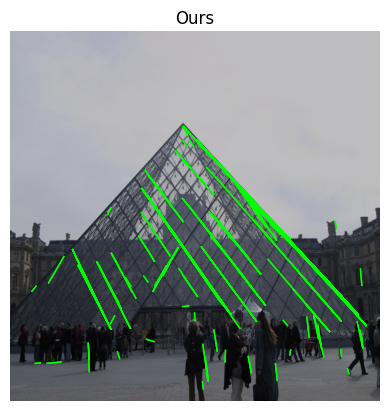

In [406]:
LINE_COLOR = 'lime'
KP_COLOR = 'r'
ALL_KP_COLOR = 'blue'

plt.title('Ours')
plt.axis('off')
# plt.imshow(npdf)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
line_segs = valid_lines
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs)):
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c=LINE_COLOR, linewidth=1)
# plt.scatter(*junctions.T[::-1], c=ALL_KP_COLOR, s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c=KP_COLOR, s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c=KP_COLOR, s=5)
# plt.legend()
plt.show()

In [789]:
def align_with_grad_angle(angle, img):
    """ Starting from an angle in [0, pi], find the sign of the angle based on
        the image gradient of the corresponding pixel. """
    # Image gradient
    img_grad_angle = compute_image_grad(img)[3]
    
    # Compute the distance of the image gradient to the angle
    # and angle - pi
    pred_grad = np.mod(angle, np.pi)  # in [0, pi]
    pos_dist = np.minimum(np.abs(img_grad_angle - pred_grad),
                          2 * np.pi - np.abs(img_grad_angle - pred_grad))
    neg_dist = np.minimum(
        np.abs(img_grad_angle - pred_grad + np.pi),
        2 * np.pi - np.abs(img_grad_angle - pred_grad + np.pi))
    
    # Assign the new grad angle to the closest of the two
    is_pos_closest = np.argmin(np.stack([neg_dist, pos_dist],
                                        axis=-1), axis=-1).astype(bool)
    new_grad_angle = np.where(is_pos_closest, pred_grad, pred_grad - np.pi)
    return new_grad_angle, img_grad_angle

def preprocess_angle(angle, img, mask=False):
    """ Convert a grad angle field into a line level angle, using
        the image gradient to get the right orientation. """
    oriented_grad_angle, img_grad_angle = align_with_grad_angle(angle, img)
    oriented_grad_angle = np.mod(oriented_grad_angle - np.pi / 2, 2 * np.pi)
    if mask:
        oriented_grad_angle[0] = -1024
        oriented_grad_angle[:, 0] = -1024
    return oriented_grad_angle.astype(np.float64), img_grad_angle

def compute_image_grad(img, ksize=7):
    blur_img = cv2.GaussianBlur(img, (ksize, ksize), 1).astype(np.float32)
    dx = np.zeros_like(blur_img)
    dy = np.zeros_like(blur_img)
    dx[:, 1:] = (blur_img[:, 1:] - blur_img[:, :-1]) / 2
    dx[1:, 1:] = dx[:-1, 1:] + dx[1:, 1:]
    dy[1:] = (blur_img[1:] - blur_img[:-1]) / 2
    dy[1:, 1:] = dy[1:, :-1] + dy[1:, 1:]
    gradnorm = np.sqrt(dx ** 2 + dy ** 2)
    gradangle = np.arctan2(dy, dx)
    return dx, dy, gradnorm, gradangle

def filter_outlier_lines(
    img, lines, df, angle, mode='inlier_thresh', use_grad=False,
    inlier_thresh=0.5, df_thresh=1.5, ang_thresh=np.pi / 6, n_samples=50):
    """ Filter out outlier lines either by comparing the average DF and
        line level values to a threshold or by counting the number of inliers
        across the line. It can also optionally use the image gradient.
    Args:
        img: the original image.
        lines: a (N, 2, 2) np array.
        df: np array with the distance field.
        angle: np array with the grad angle field.
        mode: 'mean' or 'inlier_thresh'.
        use_grad: True to use the image gradient instead of line_level.
        inlier_thresh: ratio of inliers to get accepted.
        df_thresh, ang_thresh: thresholds to determine a valid value.
        n_samples: number of points sampled along each line.
    Returns:
        A tuple with the filtered lines and a mask of valid lines.
    """
    # Get the right orientation of the line_level and the lines orientation
    oriented_line_level, img_grad_angle = preprocess_angle(angle, img)
    orientations = get_line_orientation(lines, oriented_line_level)

    # Get the sample positions
    t = np.linspace(0, 1, n_samples)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the DF and angle map
    df_samples = bilinear_interpolate_numpy(df, samples[:, 1], samples[:, 0])
    df_samples = df_samples.reshape(-1, n_samples)
    if use_grad:
        oriented_line_level = np.mod(img_grad_angle - np.pi / 2, 2 * np.pi)
    ang_samples = nn_interpolate_numpy(oriented_line_level, samples[:, 1],
                                       samples[:, 0]).reshape(-1, n_samples)

    # Check the average value or number of inliers
    if mode == 'mean':
        df_check = np.mean(df_samples, axis=1) < df_thresh
        ang_avg = np.arctan2(np.sin(ang_samples).sum(axis=1),
                             np.cos(ang_samples).sum(axis=1))
        ang_diff = np.minimum(np.abs(ang_avg - orientations),
                              2 * np.pi - np.abs(ang_avg - orientations))
        ang_check = ang_diff < ang_thresh
        valid = df_check & ang_check
    elif mode == 'inlier_thresh':
        df_check = df_samples < df_thresh
        ang_diff = np.minimum(
            np.abs(ang_samples - orientations[:, None]),
            2 * np.pi - np.abs(ang_samples - orientations[:, None]))
        ang_check = ang_diff < ang_thresh
        valid = (df_check & ang_check).mean(axis=1) > inlier_thresh
    else:
        raise ValueError("Unknown filtering mode: " + mode)

    return lines[valid], valid

def sample_along_line(lines, img, n_samples=10, mode='mean'):
    """ Sample a fixed number of points along each line and interpolate
        an img at these points, and finally aggregate the values. """
    # Get the sample positions
    t = np.linspace(0, 1, 10)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the img at the samples and aggregate the values
    if mode == 'mean':
        # Average
        val = bilinear_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.mean(val.reshape(-1, n_samples), axis=-1)
    elif mode == 'angle':
        # Average of angles
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)
        val = np.arctan2(np.sin(val).sum(axis=-1), np.cos(val).sum(axis=-1))
    elif mode == 'median':
        # Median
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.median(val.reshape(-1, n_samples), axis=-1)
    else:
        # No aggregation
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)

    return val

def nn_interpolate_numpy(img, x, y):
    xi = np.clip(np.round(x).astype(int), 0, img.shape[1] - 1)
    yi = np.clip(np.round(y).astype(int), 0, img.shape[0] - 1)
    return img[yi, xi]


def bilinear_interpolate_numpy(im, x, y):
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1] - 1)
    x1 = np.clip(x1, 0, im.shape[1] - 1)
    y0 = np.clip(y0, 0, im.shape[0] - 1)
    y1 = np.clip(y1, 0, im.shape[0] - 1)

    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return (Ia.T * wa).T + (Ib.T * wb).T + (Ic.T * wc).T + (Id.T * wd).T

def detect_afm_lines(
    img, df, line_level, filtering='normal',
    merge=False, grad_thresh=3, grad_nfa=True):
    """ Detect lines from the line distance and angle field.
        Offer the possibility to ignore line in high DF values,
        and to merge close-by lines. """
    gradnorm = np.maximum(5 - df, 0).astype(np.float64)
    angle = line_level.astype(np.float64) - np.pi / 2
    angle = preprocess_angle(angle, img, mask=True)[0]
    angle[gradnorm < grad_thresh] = -1024
    
    lines = lsd(
        img.astype(np.float64), scale=1., gradnorm=gradnorm,
        gradangle=angle, grad_nfa=grad_nfa)[:, :4].reshape(-1, 2, 2)

    # Optionally filter out lines based on the DF and line_level
    if filtering:
        if filtering == 'strict':
            df_thresh, ang_thresh = 1., np.pi / 12
        else:
            df_thresh, ang_thresh = 1.5, np.pi / 9
        angle = line_level - np.pi / 2
        lines = filter_outlier_lines(
            img, lines[:, :, [1, 0]], df, angle, mode='inlier_thresh',
            use_grad=False, inlier_thresh=0.5, df_thresh=df_thresh,
            ang_thresh=ang_thresh)[0][:, :, [1, 0]]

    # Merge close-by lines together
    if merge:
        lines = merge_lines(lines, thresh=4,
                            overlap_thresh=0).astype(np.float32)
    return lines

In [804]:
%%time

dlsd_lines = detect_afm_lines(gs_image.squeeze().numpy() * 255, npdf, npaf)
dlsd_lines.shape

CPU times: user 282 ms, sys: 50.9 ms, total: 333 ms
Wall time: 334 ms


(981, 2, 2)

In [799]:
dlsd_lines[:, :, 0]

array([[390.9002  , 389.0436  ],
       [522.02356 , 521.6438  ],
       [442.5816  , 442.50443 ],
       ...,
       [ 61.155087,  59.555782],
       [336.59763 , 339.8152  ],
       [500.07614 , 504.56638 ]], dtype=float32)

In [727]:
# plt.imshow(np.triu(res))
# plt.imshow(res)
res.shape, res.sum()

((23176,), 4.0)

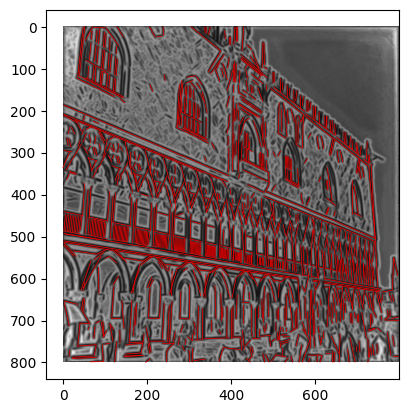

In [803]:
plt.imshow(npdf, cmap='gray')
line_segs = dlsd_lines.copy() #lines[res.nonzero()] # np.triu(res).nonzero()
# x1s, y1s = points[line_segs[0]].T
# x2s, y2s = points[line_segs[1]].T
valid_xs = line_segs[:, :, 1]
valid_ys = line_segs[:, :, 0]
for i in range(len(line_segs)):
    # x1, y1 = x1s[i], y1s[i]
    # x2, y2 = x2s[i], y2s[i]
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c='r', linewidth=0.5)
# plt.scatter(*junctions.T[::-1], c='cyan', s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c='lime', s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c='lime', s=5)
# plt.legend()
plt.show()

IndexError: index 620 is out of bounds for axis 0 with size 620

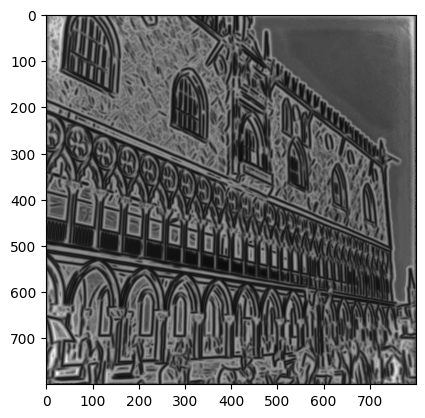

In [689]:
plt.imshow(npdf, cmap='gray')
line_segs = lines[res] # np.triu(res).nonzero()
# line_segs = np.triu(res).nonzero()
# x1s, y1s = points[line_segs[0]].T
# x2s, y2s = points[line_segs[1]].T
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs[0])):
    x1, y1 = x1s[i], y1s[i]
    x2, y2 = x2s[i], y2s[i]
    # x1, x2 = valid_xs[i]
    # y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c='r', linewidth=1)
plt.scatter(*junctions.T[::-1], c='cyan', s=1)
plt.scatter(y1s, x1s, c='lime', s=5)
plt.scatter(y2s, x2s, c='lime', s=5)
# plt.legend()
plt.show()

In [436]:
points[line_segs[1]].T

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [255]:
points.T

array([[ 67,  70,  70, 117, 125, 135, 138, 142, 143, 153, 153, 156, 157,
        157, 173, 183, 185, 196, 196, 207, 210, 212, 215, 221, 221, 222,
        222, 222, 228, 228, 234, 235, 242, 244, 245, 246, 258, 259, 260,
        260, 266, 266, 268, 272, 273, 274, 276, 276, 277, 277, 277, 278,
        278, 279, 285, 285, 286, 290, 291, 291, 292, 293, 294, 301, 309,
        314, 319, 326, 327, 337, 343, 353, 356, 360, 360, 360, 361, 366,
        366, 366, 376, 377, 384, 385, 387, 395, 396, 396, 397, 398, 400,
        401, 406, 408, 408, 408, 408, 408, 409, 412, 413, 418, 418, 419,
        423, 429, 435, 436, 443, 446, 453, 454, 465, 474, 478, 485, 491,
        498, 500, 503, 522, 526, 529, 535, 543, 546, 547, 549, 551, 553,
        554, 557, 557, 560, 562, 562, 580, 580, 582, 583, 584, 588, 588,
        589, 594, 595, 603, 604, 604, 606, 606, 613, 614, 615, 616, 647,
        648, 655, 656, 662, 662, 663, 671, 672, 675, 681, 684, 710, 711,
        711, 718, 718, 736, 740, 744, 765],
       

In [ ]:
def is_there_a_line_between(
    x1, y1, x2, y2, 
    # lines, 
    df,
    n_samples=10, 
    df_thresh=5, 
    inlier_thresh=0.7,
    r_ratio=0.1, 
    a_diff_thresh=np.pi/20, 
    a_std_thresh=np.pi/30,
    r_radius=5,
    check_sample=False,
):
    if x1 == x2 and y1 == y2:
        return False
        
    xint = np.abs(x2 - x1) / (n_samples + 1)
    yint = np.abs(y2 - y1) / (n_samples + 1)

    xs = np.linspace(x1, x2, n_samples)
    ys = np.linspace(y1, y2, n_samples)
    xs = np.round(xs).astype(int)
    ys = np.round(ys).astype(int)

    # r = int(l * r_ratio)
    r = r_radius
    xid, yid = np.mgrid[0:df.shape[0], 0:df.shape[1]]
    
    point_indices = np.array([df[max(xs[i]-r, 0):xs[i]+r+1, max(ys[i]-r, 0):ys[i]+r+1].argmin() for i in range(len(xs))])
    valid_xs = (xs + (point_indices / (r * 2 + 1) - r)).astype(int)
    valid_ys = (ys + (point_indices % (r * 2 + 1) - r)).astype(int)
    points = df[valid_xs, valid_ys]
    angles = npaf[valid_xs, valid_ys]

    xs, ys = valid_xs, valid_ys

    x1 = valid_xs[0]
    y1 = valid_ys[0]
    x2 = valid_xs[-1]
    y2 = valid_ys[-1]

    # direction = (np.arctan((y2 - y1) / (x2 - x1 + 1e-10)) + np.pi / 2)
    direction = np.mod(np.arctan((x2 - x1) / (y2 - y1 + 1e-10)), np.pi)

    # pred_grad = np.mod(angle, np.pi)  # in [0, pi]
    # pos_dist = np.minimum(np.abs(img_grad_angle - pred_grad),
    #                       2 * np.pi - np.abs(img_grad_angle - pred_grad))
    # neg_dist = np.minimum(
    #     np.abs(img_grad_angle - pred_grad + np.pi),
    #     2 * np.pi - np.abs(img_grad_angle - pred_grad + np.pi))
    
    # # Assign the new grad angle to the closest of the two
    # is_pos_closest = np.argmin(np.stack([neg_dist, pos_dist],
    #                                     axis=-1), axis=-1).astype(bool)
    # new_grad_angle = np.where(is_pos_closest, pred_grad, pred_grad - np.pi)

    inlier_indices = points < df_thresh

    inlier_ratio = (inlier_indices).sum() / len(xs)
    valid_angles = angles[inlier_indices]

    crit1 = points.mean() < df_thresh
    crit2 = valid_angles.std() < a_std_thresh
    crit3 = inlier_ratio > inlier_thresh
    crit4 = np.mod(valid_angles.mean() - direction, np.pi) < a_diff_thresh

    if check_sample:
        print("points.mean()", points.mean())
        print("direction", direction)
        print("inlier_ratio", inlier_ratio)
        print("angles.std()", angles.std())
        print("angles.mean()", angles.mean())
        print(crit1, crit2, crit3, crit4)
        plt.imshow(get_flow_vis(df, npaf))
        plt.imshow(df, alpha=0.3)

        ny = y1 + np.cos(direction) * 100
        nx = x1 + np.sin(direction) * 100
        plt.plot([y1, ny], [x1, nx], c='cyan')

        for x, y, a in zip(xs, ys, angles):
            ny = y + np.cos(a) * 15
            nx = x + np.sin(a) * 15
            plt.plot([y, ny], [x, nx], c='red', linewidth=0.75)
        
        plt.scatter(ys, xs, c='r', s=5)
        plt.scatter(valid_ys, valid_xs, c='lime', s=5)
        
        plt.show()
        # fig, ax = plt.subplots(nrows=2, ncols=2)
        # ax[0][0].imshow(crit1)
        # ax[0][1].imshow(crit2)
        # ax[1][0].imshow(crit3)
        # ax[1][1].imshow(crit4)
        # plt.show()

    return (
        crit1 & 
        crit2 & 
        crit3 & 
        crit4
    )
    # return df_check & ang_check

is_there_a_line_between(400, 105, 450, 102, npdf, check_sample=True)

In [ ]:
%%time

# res = np.zeros((len(kpx), len(kpx)))
res = np.zeros(len(lines))

# df = torch.Tensor(npdf / npdf.max())
# df = (npdf / npdf.max())
# df = normalize_df(npdf)
df = npdf.copy()
# df = torch.Tensor(npdf)
# df = -normalized_df.copy()

points = junctions.copy()

nplines = lines.numpy()

# res = is_there_a_line_between(lines, df, 300, df_thresh=0.9, a_diff_thresh=0.383, inlier_thresh=0.7)
for i in range(len(nplines)):
    x1, x2 = nplines[i, 0]
    y1, y2 = nplines[i, 1]
    res[i] = is_there_a_line_between(
        x1, y1, x2, y2, df, 
        n_samples=64, 
        df_thresh=4, 
        inlier_thresh=0.7,
        a_diff_thresh=np.pi/10,
        a_std_thresh=np.pi/10,
        # r_ratio = 0.3,
        r_radius = 5,
        # check_sample=((i % 1000)==0)
        # check_sample=((x1 > 450 and x1 < 550 and x2 > 450 and x2 < 550 and y1 > 275 and y1 < 325 and y2 > 275 and y2 < 325))
    )

In [ ]:
# plt.imshow(np_gs_image)
plt.title('Ours')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
line_segs = lines[res.nonzero()] # np.triu(res).nonzero()
# x1s, y1s = points[line_segs[0]].T
# x2s, y2s = points[line_segs[1]].T
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs)):
    # x1, y1 = x1s[i], y1s[i]
    # x2, y2 = x2s[i], y2s[i]
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c='lime')#, linewidth=0.5)
# plt.scatter(*junctions.T[::-1], c='cyan', s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c='lime', s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c='lime', s=5)
# plt.legend()
plt.show()